In [1]:
from explore_import import  *
import tpp_preprocess as tpp
import hpp_checker as hpp

import pyteomics.auxiliary as aux
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
project_palette={"canon":"orangered","trembl":"yellowgreen","openprot":"cornflowerblue",
                "Canon_unique":"salmon", "NonCanon_unique":"skyblue", "Shared":"darkkhaki",
                "Canon":"firebrick","Noncanon":"steelblue"}

In [3]:
work_dir="./../tpp_pride_reanalysis/tpp_pride_reanalysis_arch230525"
work_subdirs=["PXD002057/","PXD005833/","PXD014258/"]

### Load PeptideProphet

In [4]:
#load PeptideProphet output 

peptideprophet_combined_datasets={}
file_sufix="PeptideProphet.pep.xml"
for work_subdir in ["PXD002057","PXD005833","PXD014258"]:
    data_frames = {}
    for database in ["canon","trembl","openprot"]:
        data_frames[database]=tpp.combine_tpp(work_dir,work_subdir,database,f"_{database}_{file_sufix}")
        print(data_frames[database].shape)
    peptideprophet_combined_datasets[work_subdir[0:9]] = data_frames

(32456, 35)
(38531, 35)
(39850, 35)
(152484, 35)
(153386, 35)
(156129, 35)
(134070, 35)
(153088, 35)
(152581, 35)


### Calculate gloabl and custom FDR

In [5]:
def classify_leadprot(x):
    if 'CONTAMINANT' in x.upper():
        return 'Contam'
    elif x.startswith('II_') or x.startswith('IP_'):
        return 'NonCanon'
        # Ensembl is canonical
    else:
        return 'Canon'

def is_peptide_canonical(x):
    '''x is the list of protein classes'''
    if np.array([_=='Contam' for _ in x]).any():
        return 'Contam'
    if np.array([_=='Canon' for _ in x]).any():
        return 'Canonical'
    return 'NonCanonical'

def classifiy_mods(row):
    if len(row.modifications)==0:
        return 'Unmodified'
    else:
        return 'Expected'

def custom_subgroup_filter(data_):
    filtered_subgroups = []
    for (c,m),df in data_.groupby(['isCanonical','isModified']).__iter__():
        tmp = aux.target_decoy.qvalues(df, key='fval', reverse=True, is_decoy=df.database=='D',
                                      formula=1, full_output=True, q_label='custom_q')
        filtered_subgroups.append(tmp)

    return pd.concat(filtered_subgroups, ignore_index=True)

In [6]:
#global

for dataset, subdict in peptideprophet_combined_datasets.items():
    for database,df_ds in subdict.items():
        df_ds_new=[]
        for spectrum_file in set(df_ds.spectrum_file):
            df=df_ds.loc[df_ds.spectrum_file==spectrum_file]
            df["database"]=df["protein"].apply(tpp.get_database_tpp)
            #df=tpp.get_qval_tpp(df,score="fval")
            df = aux.target_decoy.qvalues(df,
                                            key='fval',
                                            reverse=True,
                                            is_decoy=(df.database == 'D'),
                                            q_label='global_q',
                                            formula=1,
                                            full_output=True)
            df_ds_new.append(df)
        peptideprophet_combined_datasets[dataset][database]=pd.concat(df_ds_new)

/tmp/ipykernel_68262/1004026133.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["database"]=df["protein"].apply(tpp.get_database_tpp)
/tmp/ipykernel_68262/1004026133.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["database"]=df["protein"].apply(tpp.get_database_tpp)
/tmp/ipykernel_68262/1004026133.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [7]:
#custom and hybrid

for dataset, subdict in peptideprophet_combined_datasets.items():
    for database,df_ds in subdict.items():
        df_ds_new=[]
        for spectrum_file in set(df_ds.spectrum_file):
            data=df_ds.loc[df_ds.spectrum_file==spectrum_file]

            data['protein_classes'] = data.protein.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
            
            # data['isCanonical'] = data.leadprot.apply(classify_leadprot)
            data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
            data['isModified']  = data.apply(classifiy_mods,axis=1)
        
            # Adds a columns telling you if a PSM passes the custom filters or not (custom_filter_pass)
            data2 = custom_subgroup_filter(data)
            del data
        
            # prepare for Group-walk
            data2['isTarget'] = data2.database.apply(lambda x: int(x=='T'))
            data2['FDRGroup'] = data2.isCanonical + '_' + data2.isModified
            #add hybrid
            data2["glob_cust_hybrid"]=data2.apply(lambda x: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q, axis=1)
            df_ds_new.append(data2)
        peptideprophet_combined_datasets[dataset][database]=pd.concat(df_ds_new)

/tmp/ipykernel_68262/1678907070.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.protein.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
/tmp/ipykernel_68262/1678907070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_68262/1678907070.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [8]:
#save
pickle.dump(peptideprophet_combined_datasets,open("peptideprophet_combined_datasets.pkl","wb"))

#### Compare global and cosum output

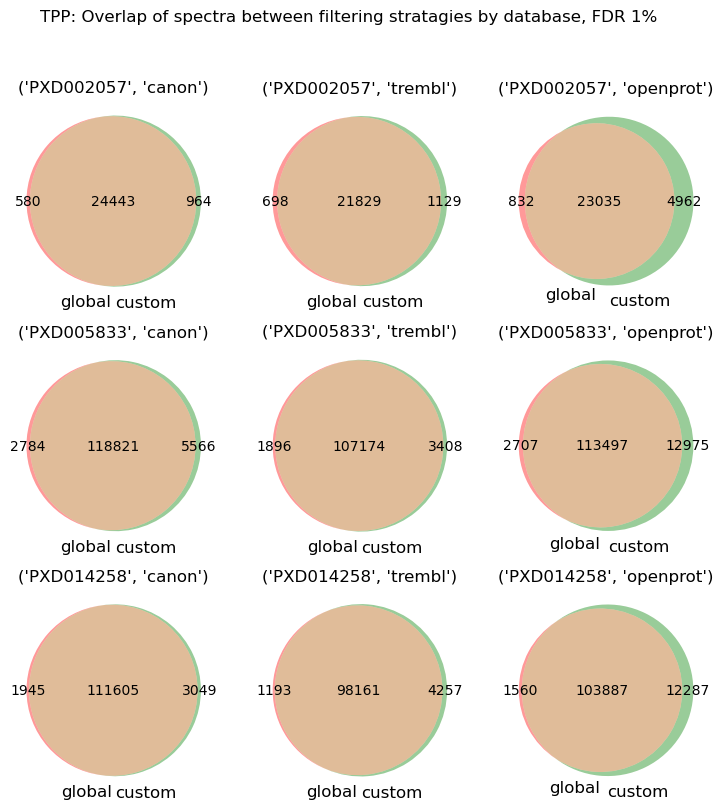

In [16]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("TPP: Overlap of spectra between filtering stratagies by database, FDR 1%")

for i,(dataset, subdict) in enumerate(peptideprophet_combined_datasets.items()):
    for j,(database,data) in enumerate(subdict.items()):
        glob=data[data['global_q']<0.01].spectrum
        cust=data[data['custom_q']<0.01].spectrum
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title((dataset,database))

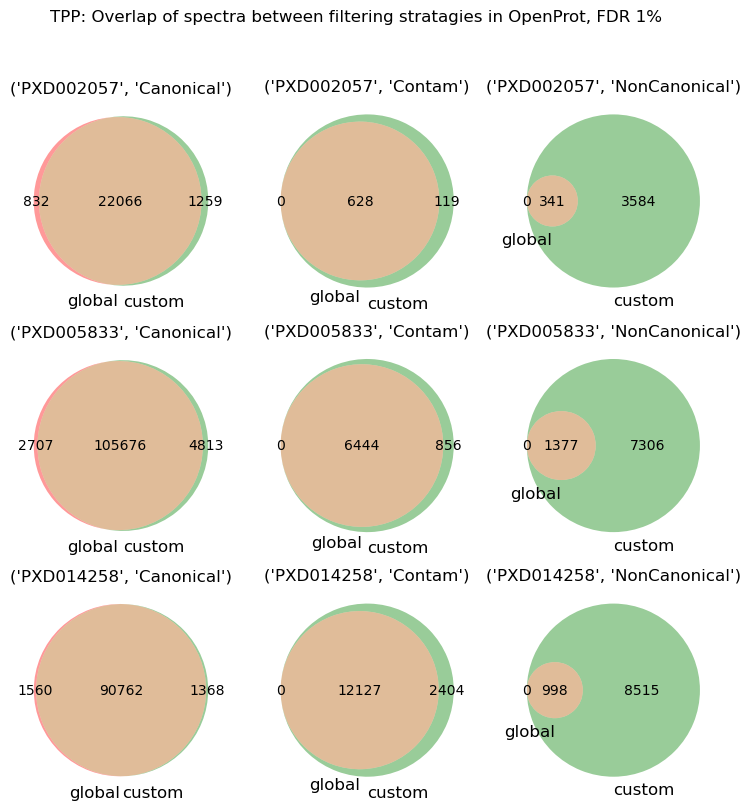

In [17]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("TPP: Overlap of spectra between filtering stratagies in OpenProt, FDR 1%")

for i,(dataset, subdict) in enumerate(peptideprophet_combined_datasets.items()):
    data=subdict["openprot"]
    for j,(isCanonical,group) in enumerate(data.groupby("isCanonical")):
        glob=group[group['global_q']<0.01].spectrum
        cust=group[group['custom_q']<0.01].spectrum
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title((dataset,isCanonical))

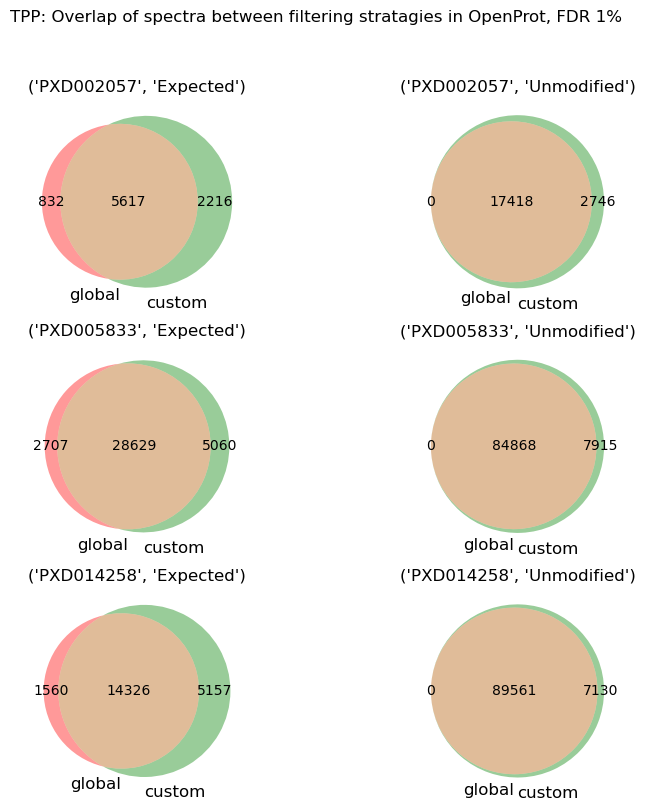

In [18]:
fig, axes = plt.subplots(3,2, figsize=(9, 9))
fig.suptitle("TPP: Overlap of spectra between filtering stratagies in OpenProt, FDR 1%")

for i,(dataset, subdict) in enumerate(peptideprophet_combined_datasets.items()):
    data=subdict["openprot"]
    for j,(isModified,group) in enumerate(data.groupby("isModified")):
        glob=group[group['global_q']<0.01].spectrum
        cust=group[group['custom_q']<0.01].spectrum
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title((dataset,isModified))

#### Save into table to do protein inference with ionbot pipeline

In [18]:
#comb_peproph=pd.DataFrame()
#for dataset, subdict in peptideprophet_combined_datasets.items():
#    for database,data in subdict.items():
#        data["searchDB"]=database
#        comb_peproph=pd.concat([comb_peproph,data])
#comb_peproph.to_csv("/group-wise-tpp-fragpipe-psm/tpp_peptideprophet_custom_unfilt.csv",index=False)

In [25]:
#hybrid - bad: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q
#comb_peproph["glob_cust_hybrid"]=comb_peproph.apply(lambda x: x["q-value"] if x.isCanonical else x["custom_q"], axis=1)
#comb_peproph.to_csv("./group-wise-tpp-fragpipe-psm/tpp_peptideprophet_custom_unfilt.csv",index=False)

In [48]:
#del comb_peproph

### Filter by hybrid q-value, decoy and contaminants

In [49]:
peptideprophet_filt_combined_datasets={"PXD002057":{},"PXD005833":{},"PXD014258":{}}
for dataset_name in peptideprophet_combined_datasets:
    for database in peptideprophet_combined_datasets[dataset_name]:
        df=peptideprophet_combined_datasets[dataset_name][database]
        peptideprophet_filt_combined_datasets[dataset_name][database]=df.loc[(df['glob_cust_hybrid']<0.01)&(df.isCanonical!="Contam")&(df.database=="T"),:]

### Identification rate by search

In [29]:
#load number of spectra in each mgf file

mgfspectraN_datasets=pickle.load(open('./../mgfspectraN_datasets.pickle', 'rb'))

In [30]:
#as tpp does not record spectra file (but merged, input), then add up corresponding merged files n of spectra

#PXD014258
mgfspectraN_datasets['PXD014258.v0.11.4']={f"{i}.mgf":np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}{j}.RAW.mgf"] for j in range(1,6)]) 
     if "BT474" not in i 
    else np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}_{j}.RAW.mgf"] for j in range(1,6)])
     for i in ["ESC-HF-Sample-BT474","ESC-HF-SampleHela","ESC-HF-Sample-MCF"]
}

In [31]:
del mgfspectraN_datasets['PXD003594.v0.11.4']

In [50]:
#ID rate on target, filtered

peprideprophet_idrate_datasets={"PXD002057":0,"PXD005833":0,"PXD014258":0}
for dataset_name in peptideprophet_filt_combined_datasets:
    idrate_med={"canon":0,"trembl":0,"openprot":0}
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    for database in idrate_med:
        df=peptideprophet_filt_combined_datasets[dataset_name][database]
        #dff=df[df["database"]=="T"]
        idrate_med[database]=list(tpp.get_idrate_tpp(mgfspectraN, df).values())
    peprideprophet_idrate_datasets[dataset_name]=idrate_med

In [51]:
peprideprophet_idrate_datasets_df=pd.DataFrame(columns=["pipeline","sample","database","value"])
for dataset in peprideprophet_idrate_datasets:
    for database in peprideprophet_idrate_datasets[dataset]:
        for i,val in enumerate(peprideprophet_idrate_datasets[dataset][database]):
            peprideprophet_idrate_datasets_df.loc[len(peprideprophet_idrate_datasets_df)]=["TPP",f"{dataset}_{i}",database,val]
peprideprophet_idrate_datasets_df.to_pickle("tpp_idrate_datasets_df.pkl")

### Searches overlap

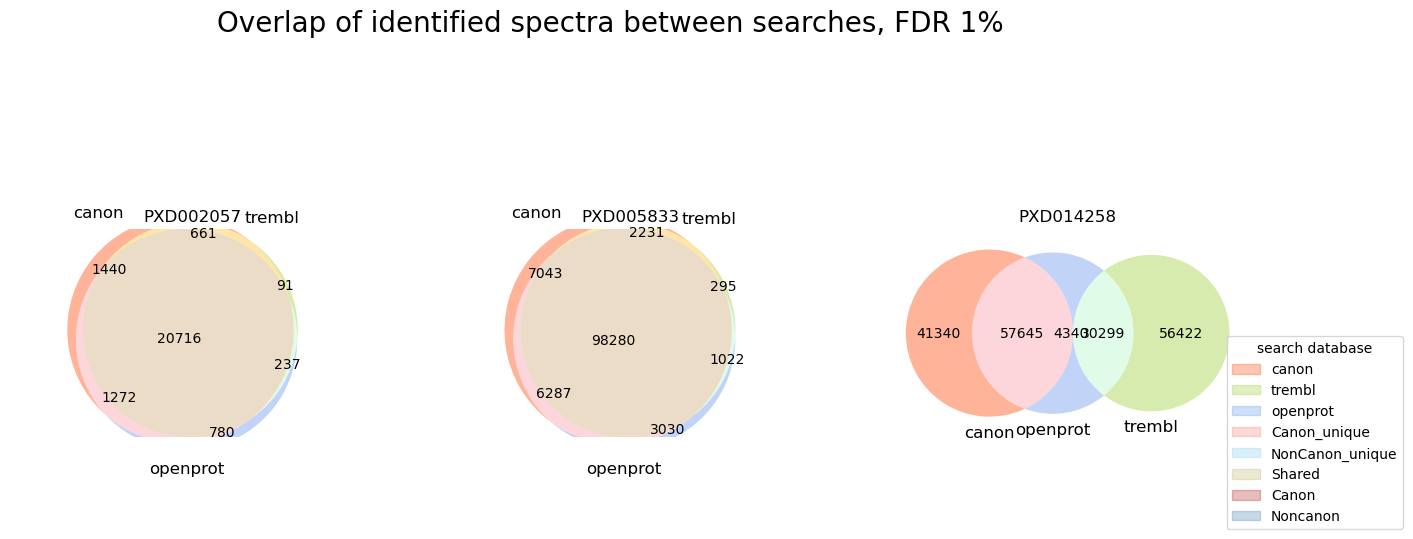

In [52]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified spectra between searches, FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(peptideprophet_filt_combined_datasets):
    dfs=list(peptideprophet_filt_combined_datasets[dataset_name].values())
    databases=list(peptideprophet_filt_combined_datasets[dataset_name].keys())
    venn3([set(dfs[0].spectrum),set(dfs[1].spectrum),set(dfs[2].spectrum)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

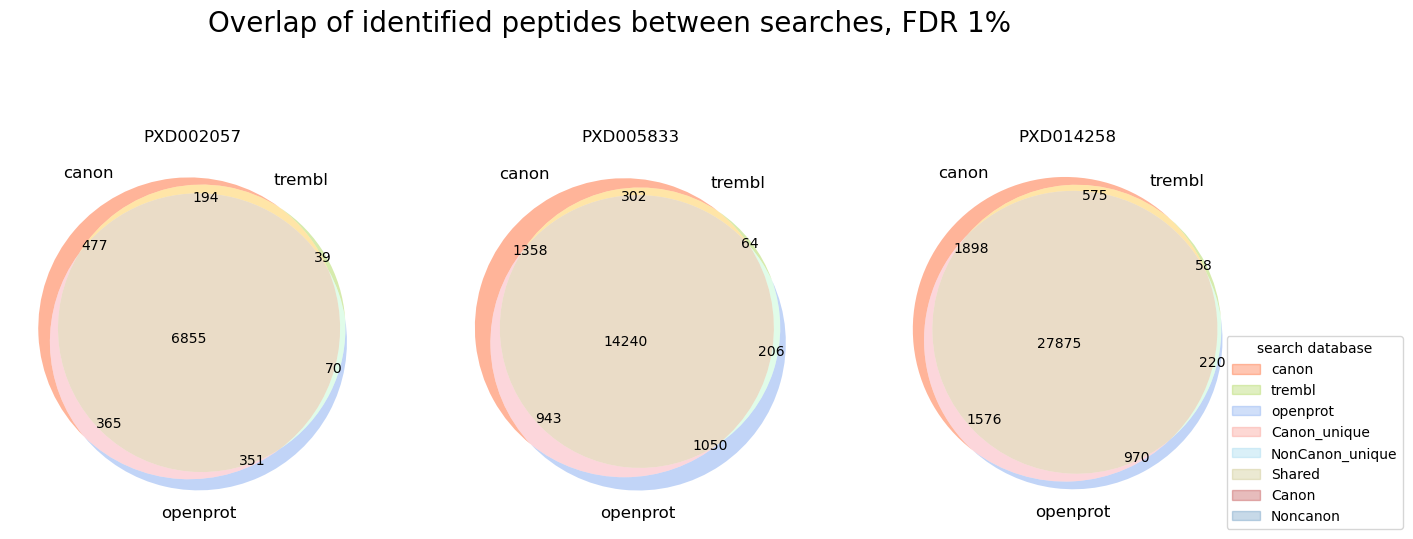

In [53]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified peptides between searches, FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(peptideprophet_filt_combined_datasets):
    dfs=list(peptideprophet_filt_combined_datasets[dataset_name].values())
    databases=list(peptideprophet_filt_combined_datasets[dataset_name].keys())
    venn3([set(dfs[0].peptide),set(dfs[1].peptide),set(dfs[2].peptide)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

### Peptide & protein class

In [54]:
#assign peptide class to each PSM

for dataset_name in peptideprophet_filt_combined_datasets:
    for database in ["canon","trembl","openprot"]: 
        df=peptideprophet_filt_combined_datasets[dataset_name][database]
        df.reset_index(inplace=True,drop=True)
        df["protein_class"]=df["protein"].apply(tpp.classify_protein_tpp)
        df["peptide_class"]=df["protein"].apply(tpp.classify_peptide_tpp) #tpp.classify_peptide_tpp
        peptideprophet_filt_combined_datasets[dataset_name][database]=df

/tmp/ipykernel_3322540/965340768.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["protein_class"]=df["protein"].apply(tpp.classify_protein_tpp)
/tmp/ipykernel_3322540/965340768.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["peptide_class"]=df["protein"].apply(tpp.classify_peptide_tpp) #tpp.classify_peptide_tpp
/tmp/ipykernel_3322540/965340768.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [55]:
with open('peptideprophet_filt_combined_datasets.pickle', 'wb') as handle:
    pickle.dump(peptideprophet_filt_combined_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
with open('peptideprophet_filt_combined_datasets.pickle', 'rb') as handle:
    peptideprophet_filt_combined_datasets=pickle.load(handle)

In [57]:
#peptides shared vs proteotypic 

pepsharedproteotyp_df=pd.DataFrame(columns=["pipeline","database","peptide_class","value"])
for database in ["canon","trembl","openprot"]:    
    df=pd.concat([peptideprophet_filt_combined_datasets[dataset_name][database] for dataset_name in peptideprophet_filt_combined_datasets])
    df=df[(df["database"]=="T")]
    counts=Counter(df.drop_duplicates(["peptide"]).peptide_class)
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["TPP",database,"shared",np.sum([val for key,val in counts.items() if "shared" in key])]
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["TPP",database,"proteotypic",np.sum([val for key,val in counts.items() if "unique" in key])]

In [58]:
pepsharedproteotyp_df.to_pickle("tpp_peptype_df.pkl")

In [59]:
pepsharedproteotyp_df

,pipeline,database,peptide_class,value
0,TPP,canon,shared,2798
1,TPP,canon,proteotypic,39446
2,TPP,trembl,shared,31191
3,TPP,trembl,proteotypic,6502
4,TPP,openprot,shared,37560
5,TPP,openprot,proteotypic,3438


### Identification rate by peptide class

In [60]:
peprideprophet_PEPCL_idrate_datasets_df=pd.DataFrame(columns=["pipeline","dataset","peptide_class","value"])
pepcl_order=["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']
datasets_index=[f"{dataset_name.replace(".v0.11.4","")}_{i}" for dataset_name,vals in mgfspectraN_datasets.items() for i in range(len(vals))]
peprideprophet_PEPCL_idrate_datasets_df["pipeline"]=["TPP"]*len(pepcl_order)*len(datasets_index)
peprideprophet_PEPCL_idrate_datasets_df["dataset"]=datasets_index*len(pepcl_order)
peprideprophet_PEPCL_idrate_datasets_df["peptide_class"]=sorted(pepcl_order*len(datasets_index))

for dataset_name in peptideprophet_filt_combined_datasets:
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    database="openprot"
    df=peptideprophet_filt_combined_datasets[dataset_name][database]
    df=df[df["database"]=="T"]
    for peptide_class in pepcl_order:        
        values=list(tpp.get_idrate_tpp(mgfspectraN, df[df.peptide_class==peptide_class]).values())
        peprideprophet_PEPCL_idrate_datasets_df.loc[(peprideprophet_PEPCL_idrate_datasets_df.dataset.str.contains(dataset_name.replace(".v0.11.4","")))&
            (peprideprophet_PEPCL_idrate_datasets_df.peptide_class==peptide_class),"value"]=values
peprideprophet_PEPCL_idrate_datasets_df.to_pickle("tpp_PEPCL_idrate_datasets_df.pkl")

### Peptides' reproducability

In [62]:
#across all samples

peptides_across_samples_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
    peptides_across_samples_l=[]
    for dataset_name in peptideprophet_filt_combined_datasets:
        df=peptideprophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=peptides_across_samples_l+list(df.drop_duplicates(["peptide","spectrum_file"]).peptide)
    
    peptides_across_samples_d=Counter(peptides_across_samples_l)
    peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/23 #number of samples
    keys=list(peptides_across_samples_d.keys())
    for i,row in enumerate(peptides_across_samples):
        peptides_across_samples_df.loc[len(peptides_across_samples_df)]=["TPP",keys[i],peptide_class,row]
peptides_across_samples_df.to_pickle("tpp_peptides_across_samples_df.pkl")

In [63]:
#across samples of same PXD

peptides_across_samples_PXD_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
    #peptides_across_samples_l=[]
    for dataset_name in peptideprophet_filt_combined_datasets:
        key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
        mgfspectraN=mgfspectraN_datasets[key]
        df=peptideprophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=list(df.drop_duplicates(["peptide","spectrum_file"]).peptide)
    
        peptides_across_samples_d=Counter(peptides_across_samples_l)
        peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/len(mgfspectraN) #number of samples
        keys=list(peptides_across_samples_d.keys())
        for i,row in enumerate(peptides_across_samples):
            peptides_across_samples_PXD_df.loc[len(peptides_across_samples_PXD_df)]=["TPP",keys[i],peptide_class,row]
peptides_across_samples_PXD_df.to_pickle("tpp_peptides_across_samples_PXD_df.pkl")

In [64]:
#count by PXD

peptides_across_samples_PEP_df=pd.DataFrame(columns=["pipeline","PXD","peptide_class","value","count"])
for dataset_name in peptideprophet_filt_combined_datasets:
    for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
        df=peptideprophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=list(df.peptide.unique())
        tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
        for spectrum_file in tmp.columns:
            tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].peptide.unique() for pep in tmp.index]
        tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["TPP",dataset_name,peptide_class,1,len(tmp[tmp["count"]==1])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["TPP",dataset_name,peptide_class,2,len(tmp[tmp["count"]==2])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["TPP",dataset_name,peptide_class,3,len(tmp[tmp["count"]==3])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["TPP",dataset_name,peptide_class,4,len(tmp[tmp["count"]>3])]

In [65]:
#add all

for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    df=pd.concat([peptideprophet_filt_combined_datasets[dataset_name]["openprot"] for dataset_name in peptideprophet_filt_combined_datasets])
    df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
    peptides_across_samples_l=list(df.peptide.unique())
    tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
    for spectrum_file in tmp.columns:
        tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].peptide.unique() for pep in tmp.index]
    tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["TPP","all",peptide_class,1,len(tmp[tmp["count"]==1])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["TPP","all",peptide_class,2,len(tmp[tmp["count"]==2])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["TPP","all",peptide_class,3,len(tmp[tmp["count"]==3])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["TPP","all",peptide_class,4,len(tmp[tmp["count"]>3])]

In [66]:
peptides_across_samples_PEP_df.to_pickle("tpp_peptides_across_samples_PEP_df.pkl")

### Number of PSMs per peptide class

In [67]:
pepcl_psm_frq={"peptide":[],"peptide_class":[],"psm_num":[]}#,"psm_frq":[]
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
    peps_dst=[]
    for dataset_name in peptideprophet_filt_combined_datasets:
        df=peptideprophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
        peps_dst=peps_dst+list(df.peptide)
    psm_dfs=pd.concat([subdict["openprot"] for dataset,subdict in peptideprophet_filt_combined_datasets.items()])
    peps_count=Counter(psm_dfs[psm_dfs.peptide.isin(peps_dst)].peptide)
    peps_count_v=list(list(peps_count.values()))
    pepcl_psm_frq["peptide"]=pepcl_psm_frq["peptide"]+list(list(peps_count.keys()))
    pepcl_psm_frq["peptide_class"]=pepcl_psm_frq["peptide_class"]+[peptide_class]*len(peps_count_v)
    pepcl_psm_frq["psm_num"]=pepcl_psm_frq["psm_num"]+[p for p in peps_count_v]
pepcl_psm_frq=pd.DataFrame(pepcl_psm_frq)

In [68]:
pepcl_psm_frq["pipeline"]="TPP"
pepcl_psm_frq["bin"]=np.nan
for bin,group in enumerate([[1],[2],list(range(3,5+1)),list(range(5,10+1)),list(range(10,15+1)),list(range(15,1000))]):
    pepcl_psm_frq.loc[pepcl_psm_frq.psm_num.isin(group),"bin"]=bin
pepcl_psm_frq.to_pickle("tpp_pepcl_psm_frq.pkl")

### Proteins

### Number of peptides & PSMs per protein per protein class

### Proteotypic peptides coverage

### Proteins reproducability

### Number of proteins per protein class